In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from scipy.integrate import quad
import symlib
import os
from glob import glob
import seaborn as sns
from scipy.stats import spearmanr
from scipy.optimize import curve_fit   
from scipy.interpolate import interp1d

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
mean_cvir = {
    "SymphonyLMC": 12.2,
    "SymphonyMilkyWay": 10.8,
    "SymphonyGroup": 9.0,
    "SymphonyLCluster": 5.0,
    "SymphonyCluster": 5.6,
}
out_dir = os.path.join(base_dir, "output", "FIGURE")

In [3]:
def ppsd_profiles(base_dir, suite_name):
    # Define input/output directories
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    mass_dir = os.path.join(base_dir, "output", suite_name, "mass_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "ppsd_profiles")
    os.makedirs(output_dir, exist_ok=True)

    # Collect file names
    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    mass_files = sorted([f for f in os.listdir(mass_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])

    # Loop through halos and compute Q_r and Q_tot
    for halo_idx, (f_rho, f_mass, f_vel) in enumerate(zip(density_files, mass_files, velocity_files)):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_mass = pd.read_csv(os.path.join(mass_dir, f_mass))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        # Load profile data
        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        m = df_mass["m_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values

        # Compute pseudo phase-space densities
        with np.errstate(divide="ignore", invalid="ignore"):
            Q_r = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)
            Q_tot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)

        # Save to CSV
        df_out = pd.DataFrame({
            "r_scaled": r,
            "m_scaled": m,
            "Q_r": Q_r,
            "Q_tot": Q_tot
        })
        df_out.to_csv(f"{base_dir}/output/{suite_name}/ppsd_profiles/halo_{halo_idx:03d}_profile.csv", index=False)

    print(f"[Saved] PPSD profiles for {suite_name} saved to {output_dir}")


In [ ]:
def raw_ppsd_profiles(base_dir, suite_name):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    mass_dir = os.path.join(base_dir, "output", suite_name, "mass_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "ppsd_profiles")
    os.makedirs(output_dir, exist_ok=True)

    # Collect file names
    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    mass_files = sorted([f for f in os.listdir(mass_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])

    # Loop through halos and compute Q_r and Q_tot
    for halo_idx, (f_rho, f_mass, f_vel) in enumerate(zip(density_files, mass_files, velocity_files)):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_mass = pd.read_csv(os.path.join(mass_dir, f_mass))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        # Load profile data
        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        m = df_mass["m_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values

        # Compute pseudo phase-space densities
        Q_r = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)
        Q_tot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)

        # Save to CSV
        df_out = pd.DataFrame({
            "r_scaled": r,
            "m_scaled": m,
            "Q_r": Q_r,
            "Q_tot": Q_tot,
        })
        df_out.to_csv(f"{base_dir}/output/{suite_name}/ppsd_profiles/halo_{halo_idx:03d}_profile.csv", index=False)

    print(f"[Saved] PPSD profiles for {suite_name} saved to {output_dir}")


In [ ]:
# NOTE: this is the version that smoothing the derivative of density and velocity sperately and then combine them to get the smoothing derivative of ppsd
def get_diff_and_optimize_funcs(method):
    submodules = [
        'kalman_smooth',
        'smooth_finite_difference',
        'finite_difference',
        'total_variation_regularization',
        'linear_model'
    ]
    for submod in submodules:
        try:
            mod_optimize = getattr(pynumdiff.optimize, submod)
            mod_diff = getattr(pynumdiff, submod)
            if hasattr(mod_optimize, method) and hasattr(mod_diff, method):
                return getattr(mod_diff, method), getattr(mod_optimize, method)
        except AttributeError:
            continue
    raise ValueError(f"Method '{method}' not found in any submodule.")

def fit_and_save_ppsd_slopes(base_dir, suite_name, method='constant_jerk', tvgamma=None):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    mass_dir = os.path.join(base_dir, "output", suite_name, "mass_profiles")
    slope_r_dir = os.path.join(base_dir, "output", suite_name, "ppsd_slope_profiles_r")
    slope_m_dir = os.path.join(base_dir, "output", suite_name, "ppsd_slope_profiles_m")
    os.makedirs(slope_r_dir, exist_ok=True)
    os.makedirs(slope_m_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    mass_files = sorted([f for f in os.listdir(mass_dir) if f.endswith(".csv")])
    n_halos = len(density_files)

    def fit_derivative(y, dt):
        try:
            diff_func, optimize_func = get_diff_and_optimize_funcs(method)
            kwargs = {'tvgamma': tvgamma} if 'tvgamma' in optimize_func.__code__.co_varnames else {}
            params, _ = optimize_func(y, dt, **kwargs)
            _, dydx = diff_func(y, dt, params)
            return dydx
        except Exception as e:
            print(f"{method} derivative fit failed: {e}")
            return None

    for halo_idx in range(n_halos):
        try:
            df_rho = pd.read_csv(os.path.join(density_dir, density_files[i]))
            df_vel = pd.read_csv(os.path.join(velocity_dir, velocity_files[i]))
            df_mass = pd.read_csv(os.path.join(mass_dir, mass_files[i]))
        except Exception as e:
            print(f"[Halo {i}] loading profiles failed: {e}")
            continue

        r = df_rho["r_scaled"].values
        m = df_mass["m_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values

        dt_r = np.diff(np.log10(r)).mean()
        dt_m = np.diff(np.log10(m)).mean()

        log_rho = np.log10(rho)
        log_sigma_tot = np.log10(sigma_tot)
        log_sigma_rad = np.log10(sigma_rad)

        drho_dlogr = fit_derivative(log_rho, dt_r)
        dsigma_tot_dlogr = fit_derivative(log_sigma_tot, dt_r)
        dsigma_rad_dlogr = fit_derivative(log_sigma_rad, dt_r)

        drho_dlogm = fit_derivative(log_rho, dt_m)
        dsigma_tot_dlogm = fit_derivative(log_sigma_tot, dt_m)
        dsigma_rad_dlogm = fit_derivative(log_sigma_rad, dt_m)

        if any(x is None for x in [drho_dlogr, dsigma_tot_dlogr, dsigma_rad_dlogr,
                                drho_dlogm, dsigma_tot_dlogm, dsigma_rad_dlogm]):
            print(f"[Halo {i}] derivative fitting failed, skipping")
            continue

        slope_Q_tot_r = drho_dlogr - 3 * dsigma_tot_dlogr
        slope_Q_rad_r = drho_dlogr - 3 * dsigma_rad_dlogr
        slope_Q_tot_m = drho_dlogm - 3 * dsigma_tot_dlogm
        slope_Q_rad_m = drho_dlogm - 3 * dsigma_rad_dlogm

        df_r = pd.DataFrame({"r_scaled": r, "slope_Q_r": slope_Q_rad_r, "slope_Q_tot": slope_Q_tot_r})
        df_m = pd.DataFrame({"m_scaled": m, "slope_Q_r": slope_Q_rad_m, "slope_Q_tot": slope_Q_tot_m})

        df_r.to_csv(os.path.join(slope_r_dir, f"slope_profile_r_{halo_idx:03d}.csv"), index=False)
        df_m.to_csv(os.path.join(slope_m_dir, f"slope_profile_m_{halo_idx:03d}.csv"), index=False)
        
for suite in suite_names:
    fit_and_save_ppsd_slopes(base_dir, suite, method='constant_jerk', tvgamma=None)

In [ ]:
# NOTE: this is the version that smooth the derivative of derivative of ppsd directly
def get_diff_and_optimize_funcs(method):
    submodules = [
        'kalman_smooth',
        'smooth_finite_difference',
        'finite_difference',
        'total_variation_regularization',
        'linear_model'
    ]
    for submod in submodules:
        try:
            mod_optimize = getattr(pynumdiff.optimize, submod)
            mod_diff = getattr(pynumdiff, submod)
            if hasattr(mod_optimize, method) and hasattr(mod_diff, method):
                return getattr(mod_diff, method), getattr(mod_optimize, method)
        except AttributeError:
            continue
    raise ValueError(f"Method '{method}' not found in any submodule.")

def fit_and_save_ppsd_slopes(base_dir, suite_name, method='constant_jerk', tvgamma=None):
    ppsd_dir = os.path.join(base_dir, "output", suite_name, "ppsd_profiles")
    slope_r_dir = os.path.join(base_dir, "output", suite_name, "ppsd_slope_profiles_r")
    slope_m_dir = os.path.join(base_dir, "output", suite_name, "ppsd_slope_profiles_m")
    os.makedirs(slope_r_dir, exist_ok=True)
    os.makedirs(slope_m_dir, exist_ok=True)

    ppsd_files = sorted([f for f in os.listdir(ppsd_dir) if f.endswith(".csv")])
    n_halos = len(ppsd_files)

    def fit_derivative(y, dt):
        try:
            diff_func, optimize_func = get_diff_and_optimize_funcs(method)
            kwargs = {'tvgamma': tvgamma} if 'tvgamma' in optimize_func.__code__.co_varnames else {}
            params, _ = optimize_func(y, dt, **kwargs)
            _, dydx = diff_func(y, dt, params)
            return dydx
        except Exception as e:
            print(f"{method} derivative fit failed: {e}")
            return None

    for halo_idx in range(n_halos):
        try:
            df_Q = pd.read_csv(os.path.join(ppsd_dir, ppsd_files[halo_idx]))
        except Exception as e:
            print(f"[Halo {i}] loading profiles failed: {e}")
            continue

        r = df_Q["r_scaled"].values
        m = df_Q["m_scaled"].values
        Q_tot = df_Q["Q_tot"].values
        Q_r = df_Q["Q_r"].values

        dt_r = np.diff(np.log10(r)).mean()
        dt_m = np.diff(np.log10(m)).mean()

        log_Q_r = np.log10(Q_r)
        log_Q_tot = np.log10(Q_tot)

        slope_Q_tot_r = fit_derivative(log_Q_tot, dt_r)
        slope_Q_rad_r = fit_derivative(log_Q_r, dt_r)
        slope_Q_tot_m = fit_derivative(log_Q_tot, dt_m)
        slope_Q_rad_m = fit_derivative(log_Q_r, dt_m)

        df_r = pd.DataFrame({"r_scaled": r, "slope_Q_r": slope_Q_rad_r, "slope_Q_tot": slope_Q_tot_r})
        df_m = pd.DataFrame({"m_scaled": m, "slope_Q_r": slope_Q_rad_m, "slope_Q_tot": slope_Q_tot_m})

        df_r.to_csv(os.path.join(slope_r_dir, f"halo_{halo_idx:03d}_profile.csv"), index=False)
        df_m.to_csv(os.path.join(slope_m_dir, f"halo_{halo_idx:03d}_profile.csv"), index=False)

for suite in suite_names:
    fit_and_save_ppsd_slopes(base_dir, suite, method='constant_jerk', tvgamma=None)

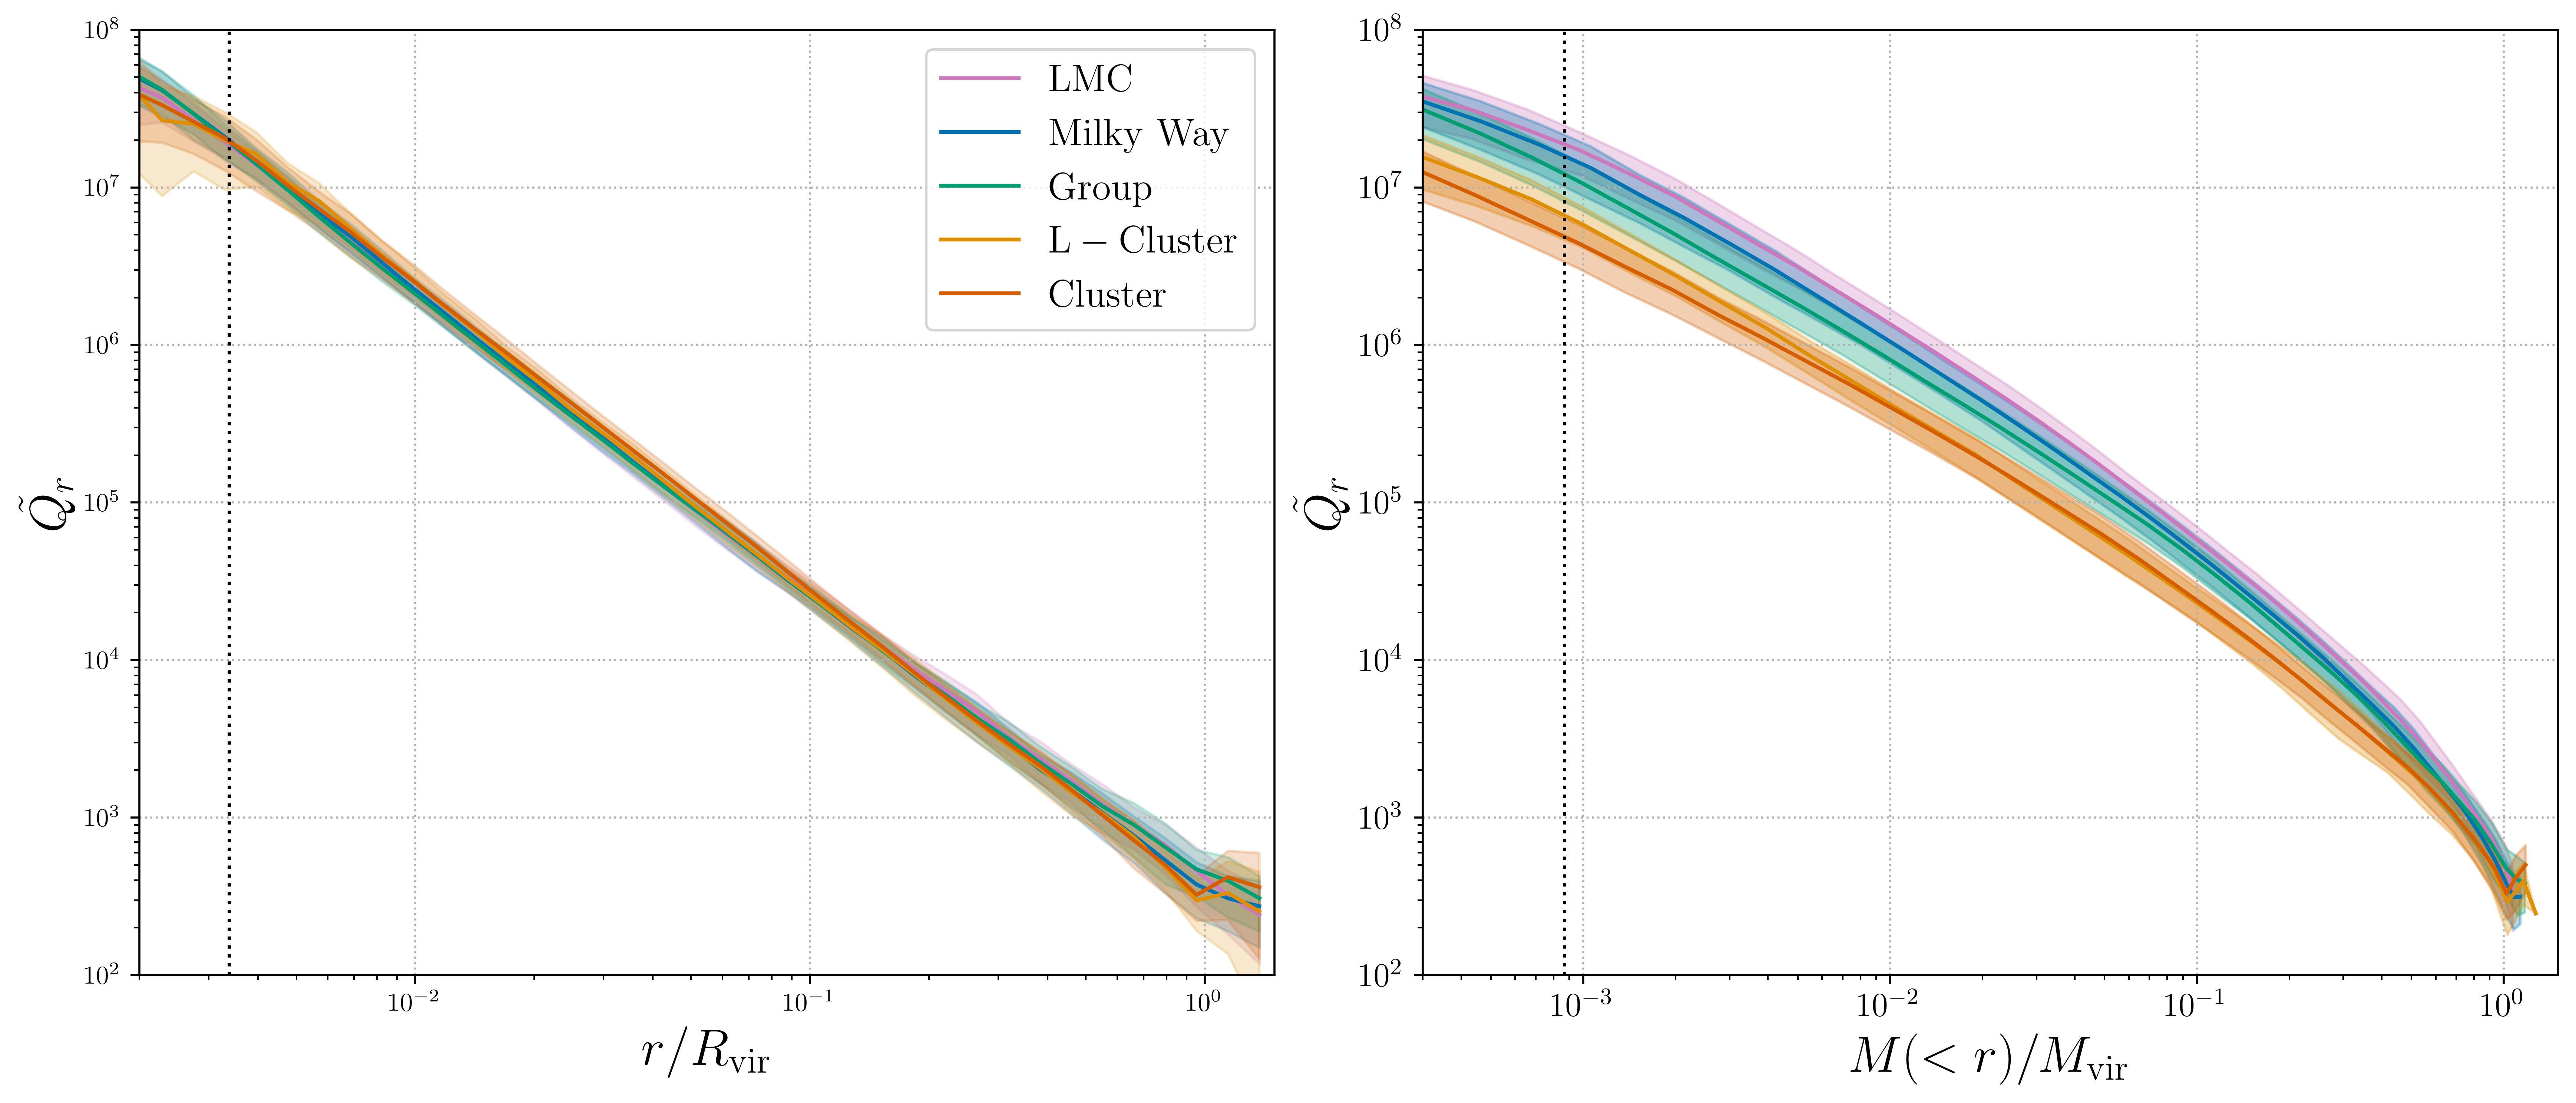

In [81]:
def plot_normalized_ppsd():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=500)
    plt.rcParams['text.usetex'] = True

    all_data = {suite: [] for suite in suite_names}
    r = None
    m = None
    convergence_radius = 3.38e-3
    convergence_masses = {}

    def interpolate_curves(x_target, x_list, y_list):
        return np.array([
            np.interp(x_target, x, y, left=np.nan, right=np.nan)
            for x, y in zip(x_list, y_list)
        ])

    for suite in suite_names:
        input_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        mass_dir = os.path.join(base_dir, "output", suite, "mass_profiles")

        files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])
        if not files:
            continue

        # Load profile axis from the first file
        r = pd.read_csv(os.path.join(input_dir, files[0]))["r_scaled"].values
        m = pd.read_csv(os.path.join(input_dir, files[0]))["m_scaled"].values

        Qr = np.array([pd.read_csv(os.path.join(input_dir, f))["Q_r"].values for f in files])
        Qtot = np.array([pd.read_csv(os.path.join(input_dir, f))["Q_tot"].values for f in files])
        all_data[suite] = [Qr, Qtot, r, m]

        m_list = [pd.read_csv(os.path.join(input_dir, f))["m_scaled"].values for f in files]
        Qr_interp_m = interpolate_curves(m, m_list, Qr)

        # Compute and store convergence mass per halo
        convergence_mass_list = []
        for f in files:
            halo_id = f.split("_")[1]
            f_mass = os.path.join(mass_dir, f.replace("ppsd", "mass"))
            if not os.path.exists(f_mass):
                continue
            df_mass = pd.read_csv(f_mass)
            r_vals = df_mass["r_scaled"].values
            m_vals = df_mass["m_scaled"].values
            m_conv = np.interp(convergence_radius, r_vals, m_vals, left=np.nan, right=np.nan)
            convergence_mass_list.append(m_conv)
        convergence_masses[suite] = np.nanmean(convergence_mass_list)

        # Plot Qr vs r (mean ± 1σ)
        mean_Qr = np.nanmean(Qr, axis=0)
        std_Qr = np.nanstd(Qr, axis=0)
        axes[0].plot(r, mean_Qr, color=sim_colors[suite], lw=1.5, label = rf"$\mathrm{{{sim_names[suite]}}}$")
        axes[0].fill_between(r, mean_Qr - std_Qr, mean_Qr + std_Qr, color=sim_colors[suite], alpha=0.2)

        # Plot Qr vs M (mean ± 1σ)
        mean_Qr_m = np.nanmean(Qr_interp_m, axis=0)
        std_Qr_m = np.nanstd(Qr_interp_m, axis=0)
        axes[1].plot(m, mean_Qr_m, color=sim_colors[suite], lw=1.5, label=sim_names[suite])
        axes[1].fill_between(m, mean_Qr_m - std_Qr_m, mean_Qr_m + std_Qr_m, color=sim_colors[suite], alpha=0.3)

    # Add convergence radius line 
    axes[0].set_xlim(2e-3, 1.5)
    axes[0].set_ylim(1e2, 1e8)
    axes[0].set_xlabel(r"$r / R_{\mathrm{vir}}$",fontsize=20)
    axes[0].set_ylabel(r"$\tilde{Q_r}$",fontsize=20)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].grid(True, which="major", linestyle=":")
    axes[0].axvline(convergence_radius, ls=":" ,lw=1.3, color='black')
    axes[0].legend(fontsize=15, loc="best", frameon=True)

    # Add convergence mass line 
    max_conv_mass = np.nanmax(list(convergence_masses.values()))
    axes[1].set_xlim(3e-4, 1.5)
    axes[1].set_ylim(1e2, 1e8)
    axes[1].set_xlabel(r"$M(<r) / M_{\mathrm{vir}}$",fontsize=20)
    axes[1].set_ylabel(r"$\tilde{Q_r}$",fontsize=20)
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")
    axes[1].grid(True, which="major", linestyle=":")
    axes[1].axvline(max_conv_mass, ls=":", lw=1.3, color='black')

    fig.tight_layout(rect=[0, 0, 1, 1])
    save_path = os.path.join(out_dir, "normalized_ppsd_profiles.pdf")
    plt.tick_params(axis='both', labelsize=13)
    plt.savefig(save_path, format="pdf")
    plt.show()
    plt.close(fig)

plot_normalized_ppsd()

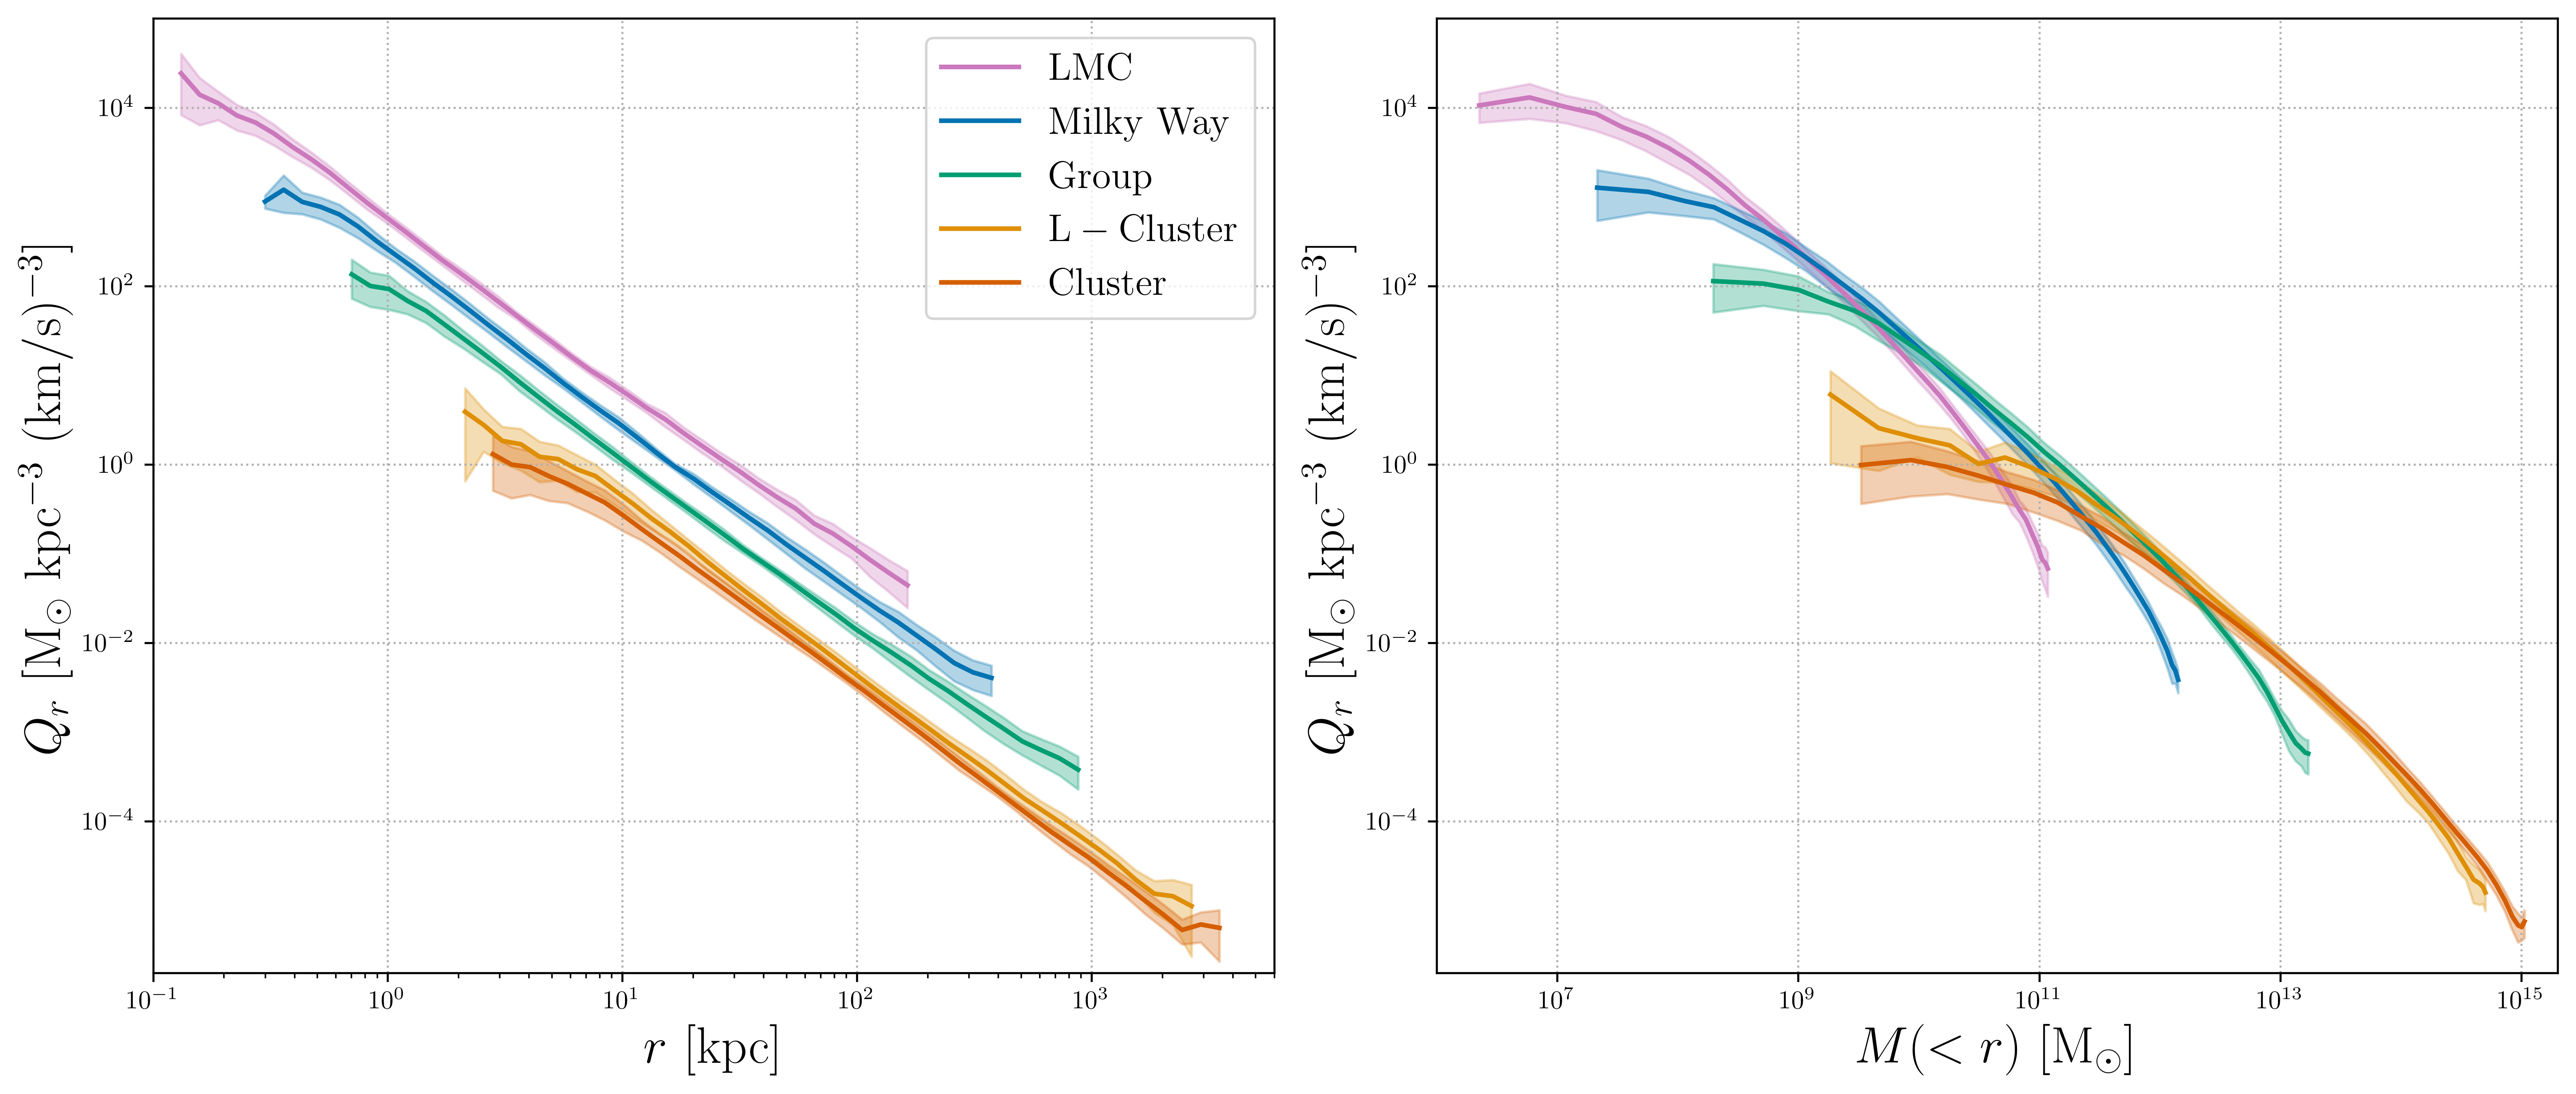

In [80]:
def plot_dimensional_ppsd():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=500)
    plt.rcParams['text.usetex'] = True

    for suite in suite_names:
        input_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")

        files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])
        # Load halo-specific virial quantities
        rvir_df = pd.read_csv(os.path.join(base_dir, "output", suite, "virial_radius.csv"),dtype={"halo_id": str})
        vvir_df = pd.read_csv(os.path.join(base_dir, "output", suite, "virial_velocity.csv"),dtype={"halo_id": str})
        mvir_df = pd.read_csv(os.path.join(base_dir, "output", suite, "halo_mass.csv"),dtype={"halo_id": str})

        # Compute background density
        params = symlib.simulation_parameters(suite)
        H0_si = params["H0"] * u.km / u.s / u.Mpc
        G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
        rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
        rho_m = params["Om0"] * rho_crit

        Qr_list, r_list, m_list= [], [], []

        for f in files:
            halo_id = f.split("_")[1]
            profile = pd.read_csv(os.path.join(input_dir, f))
            # Scaled variables
            r_scaled = profile["r_scaled"].values
            m_scaled = profile["m_scaled"].values
            Qr_dimensionless = profile['Q_r'].values

            # Halo virial values
            Rvir = float(rvir_df.loc[rvir_df["halo_id"] == halo_id, "rvir"].values[0])
            Vvir = float(vvir_df.loc[vvir_df["halo_id"] == halo_id, "vvir"].values[0])
            Mvir = float(mvir_df.loc[mvir_df["halo_id"] == halo_id, "mvir"].values[0])
            
            # Dimensional quantities
            r = r_scaled * Rvir
            m = m_scaled * Mvir
            Qr_dimensional = Qr_dimensionless * rho_m / Vvir**3

            # Save for plotting
            Qr_list.append(Qr_dimensional)
            r_list.append(r)
            m_list.append(m)

        # Stack arrays for interpolation and mean
        r_common = r_list[0]
        m_common = np.nanmean(np.vstack(m_list), axis=0)
        Qr_r = np.array([np.interp(r_common, r, q, left=np.nan, right=np.nan) for r, q in zip(r_list, Qr_list)])
        Qr_m = np.array([np.interp(m_common, m, q, left=np.nan, right=np.nan) for m, q in zip(m_list, Qr_list)])

        from astropy.stats import sigma_clip
        Qr_r_clipped = sigma_clip(Qr_r, sigma=3, axis=0)
        Qr_m_clipped = sigma_clip(Qr_m, sigma=3, axis=0)
        mean_Qr_r = np.nanmean(Qr_r_clipped, axis=0)
        std_Qr_r  = np.nanstd(Qr_r_clipped, axis=0)
        mean_Qr_m = np.nanmean(Qr_m_clipped, axis=0)
        std_Qr_m = np.nanstd(Qr_m_clipped, axis=0)

        # Plot Q_r vs r
        axes[0].plot(r_common, mean_Qr_r, color=sim_colors[suite], lw=1.8, label = rf"$\mathrm{{{sim_names[suite]}}}$")
        axes[0].fill_between(r_common, mean_Qr_r - std_Qr_r, mean_Qr_r + std_Qr_r,
                             color=sim_colors[suite], alpha=0.3)

        # Plot Q_r vs M
        axes[1].plot(m_common, mean_Qr_m, color=sim_colors[suite], lw=1.8, label=sim_names[suite])
        axes[1].fill_between(m_common, mean_Qr_m - std_Qr_m, mean_Qr_m + std_Qr_m,
                             color=sim_colors[suite], alpha=0.3)

    # Final plot styling
    axes[0].set_xlabel(r"$r\ [{\rm kpc}]$", fontsize=20)
    axes[0].set_ylabel(r"$Q_r\ [{\rm M_\odot\ kpc^{-3}\ (km/s)^{-3}}]$", fontsize=20)
    axes[0].set_xlim(1e-1, 6e3)
    axes[0].set_ylim(2e-6, 1e5)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].grid(True, which="major", linestyle=":")
    axes[0].legend(fontsize=15, loc="best", frameon=True)

    axes[1].set_xlabel(r"$M(<r)\ [{\rm M_\odot}]$", fontsize=20)
    axes[1].set_ylabel(r"$Q_r\ [{\rm M_\odot\ kpc^{-3}\ (km/s)^{-3}}]$", fontsize=20)
    axes[1].set_xlim(1e6, 2e15)
    axes[1].set_ylim(2e-6, 1e5)
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")
    axes[1].grid(True, which="major", linestyle=":")

    fig.tight_layout()
    save_path = os.path.join(out_dir, "dimensional_ppsd_profiles.pdf")
    for ax in axes:
        ax.tick_params(which='minor', labelsize=13)
    plt.savefig(save_path)
    plt.show()
    plt.close(fig)

plot_dimensional_ppsd()

[Skip] halo_id 072 missing in one of the meta tables


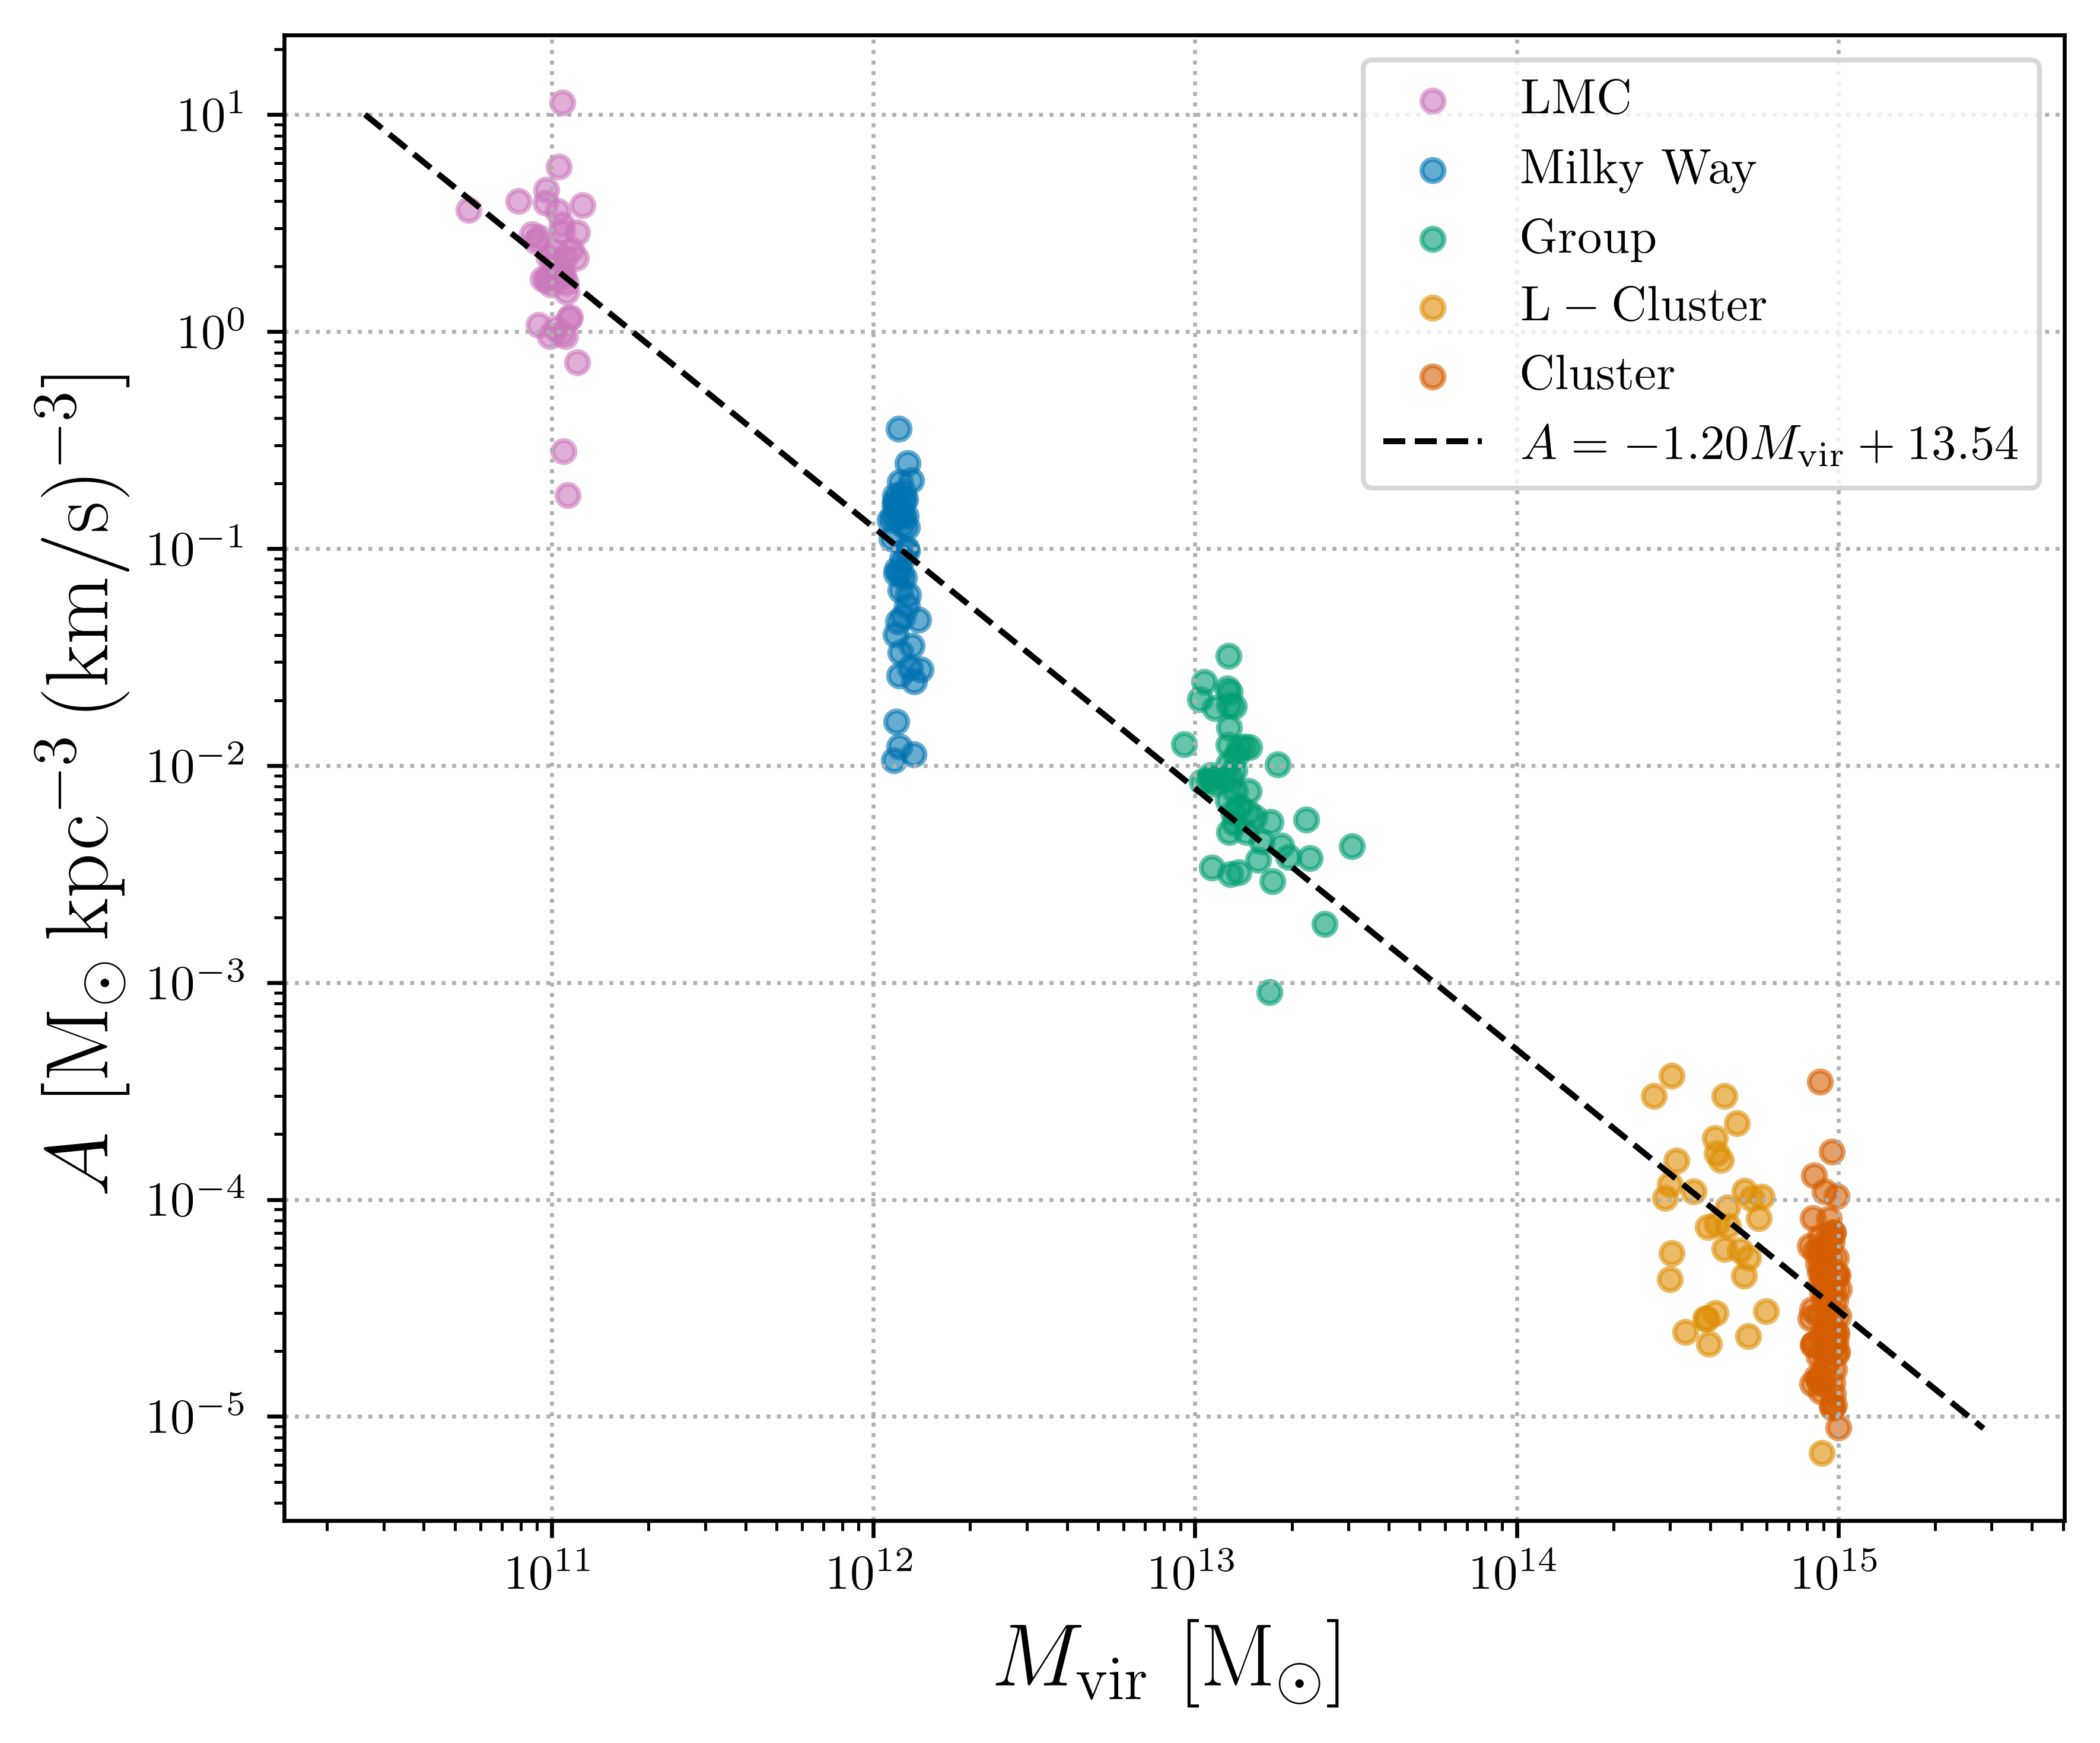

Spearman ρ (all halos) = -0.930  (p = 2.017e-107)
SymphonyLMC       :  ρ = -0.283,   p = 8.086e-02
SymphonyMilkyWay  :  ρ = -0.189,   p = 2.139e-01
SymphonyGroup     :  ρ = -0.574,   p = 1.585e-05
SymphonyLCluster  :  ρ = -0.196,   p = 2.738e-01
SymphonyCluster   :  ρ = -0.086,   p = 4.559e-01


<Figure size 640x480 with 0 Axes>

In [78]:
def fit_powerlaw(x, y, min_pts=5):
    """Return (A, alpha) for y = A x^{-alpha} in log–log space."""
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    if mask.sum() < min_pts:
        return np.nan, np.nan
    logx, logy = np.log10(x[mask]), np.log10(y[mask])
    slope, intercept = np.polyfit(logx, logy, 1)
    alpha = -slope
    A = 10 ** intercept
    return A, alpha


def gather_normalizations():
    records = []
    for suite in suite_names:
        in_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        files = sorted(f for f in os.listdir(in_dir) if f.endswith(".csv"))
        rvir_df = pd.read_csv(os.path.join(base_dir, "output", suite, "virial_radius.csv"),
                              dtype={"halo_id": str})
        vvir_df = pd.read_csv(os.path.join(base_dir, "output", suite, "virial_velocity.csv"),
                              dtype={"halo_id": str})
        mvir_df = pd.read_csv(os.path.join(base_dir, "output", suite, "halo_mass.csv"),
                              dtype={"halo_id": str})
        rvmax_df = pd.read_csv(os.path.join(base_dir, "output", suite, "max_radius.csv"),
                               dtype={"halo_id": str})
        params = symlib.simulation_parameters(suite)
        H0_si = params["H0"] * u.km / u.s / u.Mpc
        G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
        rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
        rho_m = params["Om0"] * rho_crit

        for f in files:
            halo_id = f.split("_")[1]
            prof = pd.read_csv(os.path.join(in_dir, f))
            r_scaled = prof["r_scaled"].values
            Q_rls = prof["Q_r"].values

            if (
                halo_id not in rvir_df["halo_id"].values or
                halo_id not in vvir_df["halo_id"].values or
                halo_id not in rvmax_df["halo_id"].values
            ):
                print(f"[Skip] halo_id {halo_id} missing in one of the meta tables")
                continue

            Rvir = float(rvir_df.loc[rvir_df.halo_id == halo_id, "rvir"].values[0])
            Vvir = float(vvir_df.loc[vvir_df.halo_id == halo_id, "vvir"].values[0])
            Mvir = float(mvir_df.loc[mvir_df.halo_id == halo_id, "mvir"].values[0])
            Rvmax = float(rvmax_df.loc[rvmax_df.halo_id == halo_id, "rvmax"].values[0])

            r_norm = (r_scaled * Rvir) / Rvmax
            Q_dim = Q_rls * rho_m / Vvir ** 3
            A, alpha = fit_powerlaw(r_norm, Q_dim)
            records.append({"suite": suite, "halo_id": halo_id,
                            "A": A, "alpha": alpha, "Mvir": Mvir})
    return pd.DataFrame(records)


def plot_A_vs_mass(df):
    fig, ax = plt.subplots(figsize=(6, 5), dpi=600)
    plt.rcParams['text.usetex'] = True

    for suite in suite_names:
        sub = df[df["suite"] == suite]
        ax.scatter(sub["Mvir"], sub["A"], s=20,
                   color=sim_colors[suite], label = rf"$\mathrm{{{sim_names[suite]}}}$", alpha=0.6)

    # global best-fit line in log–log space
    finite = df[["A", "Mvir"]].dropna()
    logM, logA = np.log10(finite["Mvir"].values), np.log10(finite["A"].values)
    slope, intercept = np.polyfit(logM, logA, 1)
    x_line = np.logspace(logM.min() * 0.97, logM.max() * 1.03, 200)
    ax.plot(x_line, 10 ** (intercept + slope * np.log10(x_line)),
            "k--", lw=1.2, label=rf"$A={slope:.2f}M_{{\mathrm{{vir}}}}+{intercept:.2f}$")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$M_{\mathrm{vir}}\ [{\rm M_\odot}]$", fontsize=18)
    ax.set_ylabel(r"$A\ [{\rm M_\odot\,kpc^{-3}\,(km/s)^{-3}}]$", fontsize=18)
    ax.grid(True, which="major", ls=":")
    ax.legend(fontsize=10, frameon=True)
    fig.tight_layout()
    plt.show()
    plt.savefig(os.path.join(out_dir, f"ppsd_norm_mass_relation.pdf"))

    plt.close(fig)

def norm_mass_relation():
    df = gather_normalizations()
    plot_A_vs_mass(df)
    valid = df[["A", "Mvir"]].dropna()
    rho, pval = spearmanr(np.log10(valid["A"]), np.log10(valid["Mvir"]))
    print(f"Spearman ρ (all halos) = {rho:.3f}  (p = {pval:.3e})")
    for suite in suite_names:
        sub = df[df["suite"] == suite][["A", "Mvir"]].dropna()
        if len(sub) < 3:
            print(f"{suite}: insufficient halos for Spearman test")
            continue
        rho_s, pval_s = spearmanr(np.log10(sub["A"]), np.log10(sub["Mvir"]))
        print(f"{suite:18s}:  ρ = {rho_s:.3f},   p = {pval_s:.3e}")

norm_mass_relation()
